In [49]:
import SimpleITK as sitk
import numpy as np
import csv
import os
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import cv2

### Utilities

In [ ]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(itkimage.GetOrigin()[::-1])
    numpySpacing = np.array(itkimage.GetSpacing()[::-1])
    return itkimage, numpyImage, numpyOrigin, numpySpacing


def read_csv(filename):
    lines = []
    with open(filename, "r") as f:
        reader = csv.reader(f)
        for line in reader:
            lines.append(line)
    return lines


def world_to_voxel_coord(world_coord, origin, spacing):
    stretched_voxel_coord = np.absolute(world_coord - origin)
    voxel_coord = stretched_voxel_coord / spacing
    return voxel_coord


def normalize_planes(npzarray):
    maxHU = 350.0
    minHU = -1150.0
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray > 1] = 1.0
    npzarray[npzarray < 0] = 0.0
    return npzarray

In [ ]:
img_path = (
    "data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd"
)
itk_img, np_img, np_origin, np_spacing = load_itk_image(img_path)
print(np_img.shape)
print(np_origin)
print(np_spacing)

In [32]:
os.makedirs("patches_nd", exist_ok=True)
fname = os.path.splitext(os.path.basename(img_path))[0]
subset = os.path.dirname(img_path).split(os.sep)[1]

In [33]:
old_size = itk_img.GetSize()
old_spacing = itk_img.GetSpacing()
print(old_size)
print(old_spacing)

(512, 512, 119)
(0.7421879768371582, 0.7421879768371582, 2.5)


In [48]:
new_spacing = np.array([old_spacing[0], old_spacing[1], 1.0])
new_size = np.array(old_size * (old_spacing / new_spacing)).astype(int).tolist()
print(new_size)
print(new_spacing)

[512, 512, 297]
[0.74218798 0.74218798 1.        ]


In [65]:
resampled = sitk.Resample(
    itk_img,
    new_size,
    sitk.Transform(),
    sitk.sitkLinear,
    itk_img.GetOrigin(),
    new_spacing,
    itk_img.GetDirection(),
    -1000.,
    itk_img.GetPixelID()
)
im = sitk.GetArrayFromImage(resampled)
out = np.full((im.shape[0], 1024, 1024), -1000)
for i in range(im.shape[0]):
    out[i] = cv2.resize(im[i, :, :], (1024, 1024), interpolation=cv2.INTER_LINEAR)
norm = normalize_planes(out.astype(np.float32))


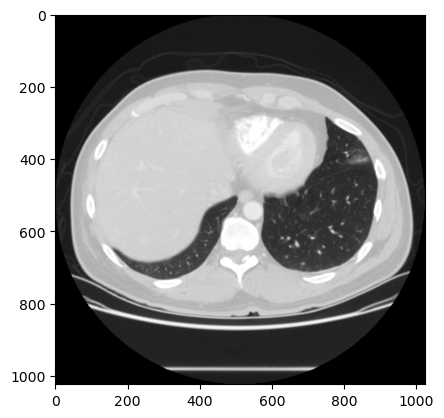

In [67]:
plt.imshow(norm[60], cmap='gray')

In [ ]:
slicer = np.load('1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.npy')
plt.imshow(slicer[60], cmap='gray')